#### Task 1: 
- Team: (20 points)
    - Develop Linear and Non-Linear (polynomial with degree n) regression models for predicting cases and deaths in US. 
        - Start your data from 2020.06.01 (Monday) to 2021.01.03 (Sunday) of infections in US.
            X-Axis - number of days, Y-Axis - number of new cases and deaths. (5 points)
        - Calculate and report Root Mean Square Error (RMSE) for your models (linear and non-linear). https://en.wikipedia.org/wiki/Root-mean-square_deviation. Discuss bias versus variance tradeoff. (5 points)
        - Plot trend line along for the data along with the forecast of 1 week ahead (i.e. make prediction on 2021.01.04 - 2021.01.10). (5 points)
        - Describe the trends as compared to other countries. (5 points)

In [1]:
#!pip install --user ipykernel
#!pip install sktime
#!pip install ipython
#!pip install -U kaleido

In [2]:
#imports
import pandas as pd
import numpy as np
import datetime
from sklearn.linear_model import LinearRegression
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import make_reduction
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import IPython
import plotly.graph_objects as go

In [3]:
#read in csv files
cases = pd.read_csv("covid_confirmed_usafacts.csv")
deaths = pd.read_csv("covid_deaths_usafacts.csv")

In [4]:
def get_dates(data): #function from stage 2
    dates = data.loc[:, [i not in ["countyFIPS","County Name", "State", "StateFIPS"] for i in data]] #Extract non dates
    
    dates.columns = pd.to_datetime(dates.columns) #Fix columns to be date times
    
    dates = dates.loc[:, [(i >= datetime.datetime(2020, 5, 25)) and (i <= datetime.datetime(2021, 1, 10)) for i in dates]] #Extract correct time
    return dates #make dates start 1 week earlier for get_weekly() purposes

def get_weekly(dates): #tweaked function from stage 2

    weeks = [range(i, i + 7) for i in range(0, len(dates.columns), 7)]
    dates.iloc[:, weeks[0]]
    
    stats = pd.DataFrame({"week": [],"sum" : []})
    
    for i in range(len(weeks)-1):
        date = dates.iloc[:, weeks[i+1]].iloc[0, :].keys()[0]
        #Subtract numbers from previous week to get new case/death data (current data is cumulative)
        week = (dates.iloc[:, weeks[i+1]].sum(axis = 1)) - (dates.iloc[:, weeks[i]].sum(axis = 1))
        wsum = week.sum()/7/7
        new_row = pd.DataFrame({"week": date,"sum" : (wsum)}, index=[i])
        stats = pd.concat([stats, new_row])
    return stats

In [5]:
#set up data
cases_dates = get_dates(cases)
cases_weeks = get_weekly(cases_dates)
cases_weeks.dropna(inplace=True)
deaths_dates = get_dates(deaths)
deaths_weeks = get_weekly(deaths_dates)
deaths_weeks.dropna(inplace=True)

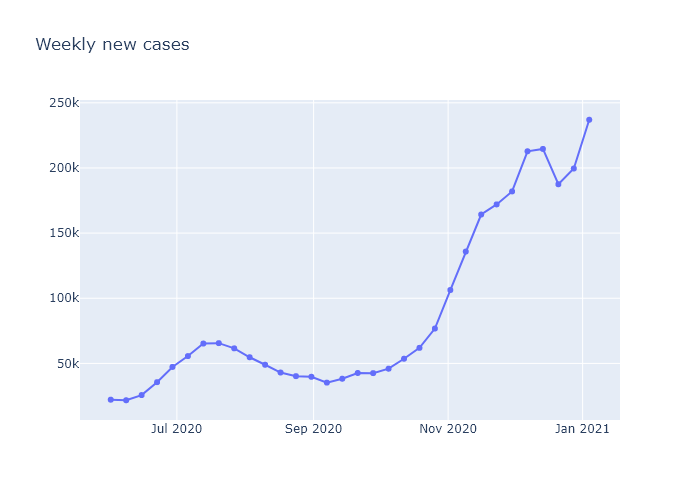

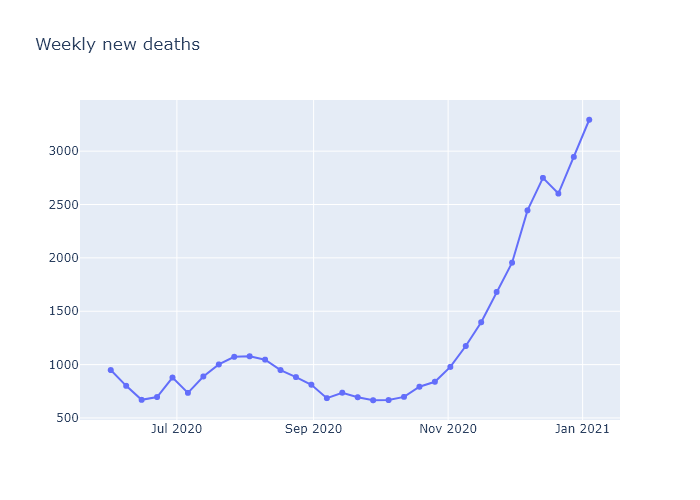

In [6]:
#plot actual case data
fig = go.Figure()
fig.add_trace(go.Scatter(x=cases_weeks["week"], y=cases_weeks["sum"], mode='lines+markers'))
fig.update_layout(title = "Weekly new cases")
IPython.display.display(IPython.display.Image(fig.to_image(format = "png"))) #Return static image for viewing
fig = go.Figure()
fig.add_trace(go.Scatter(x=deaths_weeks["week"], y=deaths_weeks["sum"], mode='lines+markers'))
fig.update_layout(title = "Weekly new deaths")
IPython.display.display(IPython.display.Image(fig.to_image(format = "png"))) #Return static image for viewing

In [7]:
# Regression plot function (does both linear and polynomial)
def create_reg_plot(data_weekly, cd = None, degree = 1, title = None, loc=None):
    #data_dates = get_dates(data)
    #data_weekly = get_weekly(data_dates)
    #Make cases have an int rather than a date for regression.
    data_weekly["week"] = [i for i in range(len(data_weekly))]
    X = data_weekly["week"]
    y = data_weekly["sum"]
    
    y_train, y_test = temporal_train_test_split(y, test_size=1)
    poly_features = PolynomialFeatures(degree = degree)
    regressor = make_pipeline(poly_features, LinearRegression())
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    forecaster = make_reduction(regressor, window_length=1, strategy="recursive")
    print(fh)
    
    # Get regression line
    X = np.array(data_weekly["week"]).reshape(-1,1)
    X_poly = poly_features.fit_transform(X)
    #print(X_poly)
    
    lin_reg = LinearRegression()
    lin_reg.fit(X_poly, data_weekly["sum"])
    
    X_reg = poly_features.fit_transform(np.array([i for i in range(len(data_weekly))]).reshape(-1,1))
    X_plot = np.array([i for i in range(len(data_weekly))]).reshape(-1,1)
    y_reg = lin_reg.predict(X_reg)
    
    reg_df = pd.DataFrame(X_plot, columns = ["X_plot"])
    y_frame = pd.DataFrame(y_reg, columns = ["y_reg"])
    
    reg_df = reg_df.join(y_frame)

    # Predict next week of data
    forecaster.fit(y_train)
    y_predict = forecaster.predict(fh)
    
    std_error = np.sqrt(mean_squared_error(y_test,y_predict)) 
    #print(std_error)
    
    intervel = 1.96 * std_error
    
    #Initial plot
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=y_train.index, y=y_train, mode='lines+markers', name="previous data"))
    fig.add_trace(go.Scatter(x=reg_df["X_plot"], y=reg_df["y_reg"], mode='lines', name="regression line"))
    fig.add_trace(go.Scatter(x=y_predict.index, y=y_predict, mode='lines+markers', name="predicted values",
                            error_y = {"type": "constant", "value": intervel}))
    fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines+markers', name="true values"))
    
    #fig.add_scatter(x = reg_df["X"], y = reg_df["y"], name = "actual data", mode='lines+markers')
    #fig.add_scatter(x = y_test.index, y = y_test, name = "test data")
    #fig.add_scatter(x = predict_df["X"], y = predict_df["y_predict"], name = "linear prediction", mode='lines+markers',
                    #error_y = {"type": "constant", "value": intervel})
        
    if(cd == "c") :
        fig.update_layout(xaxis_title='Week', yaxis_title='New Cases')
    elif(cd == "d") :
        fig.update_layout(xaxis_title='Week', yaxis_title='New Deaths')
    else :
        fig.update_layout(xaxis_title='Week', yaxis_title='New Cases/Deaths')
    
    if title != None:
        #plt.title(title)
        fig.update_layout(title = title)
    
        
    #fig.show()
    IPython.display.display(IPython.display.Image(fig.to_image(format = "png"))) #Return static image for viewing
    print("RMSE: {}".format(std_error))
    
#degree for polynomial
degree = 2

ForecastingHorizon([31], dtype='int64', is_relative=False)


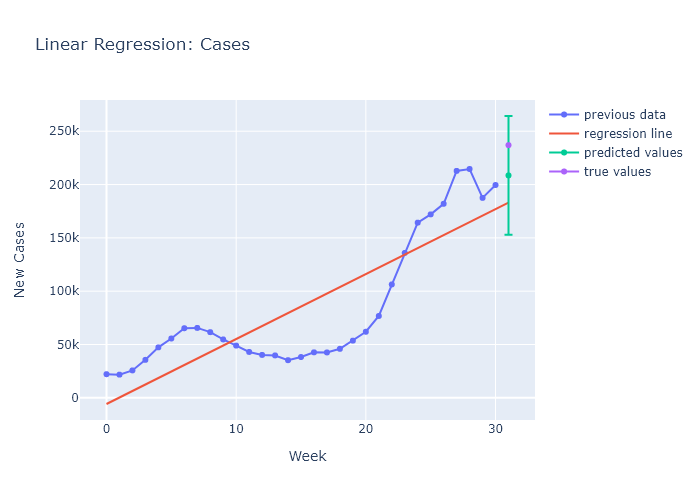

RMSE: 28434.82194498388
ForecastingHorizon([31], dtype='int64', is_relative=False)


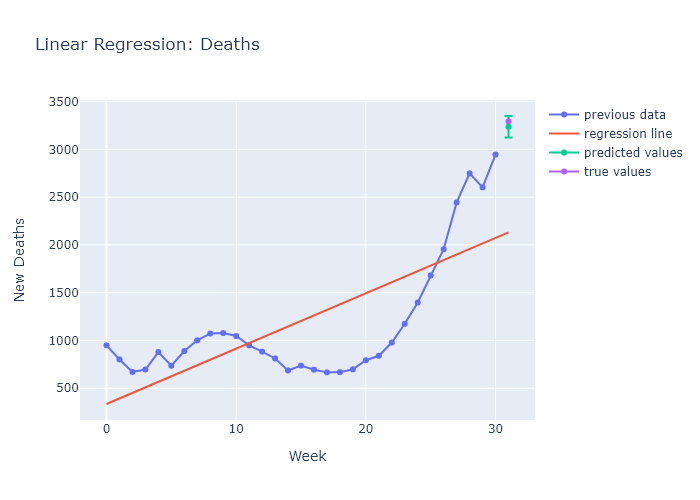

RMSE: 57.709831164120715


In [8]:
# Plot Linear Regression
create_reg_plot(cases_weeks, cd = "c", title="Linear Regression: Cases")
create_reg_plot(deaths_weeks, cd = "d", title="Linear Regression: Deaths")

ForecastingHorizon([31], dtype='int64', is_relative=False)


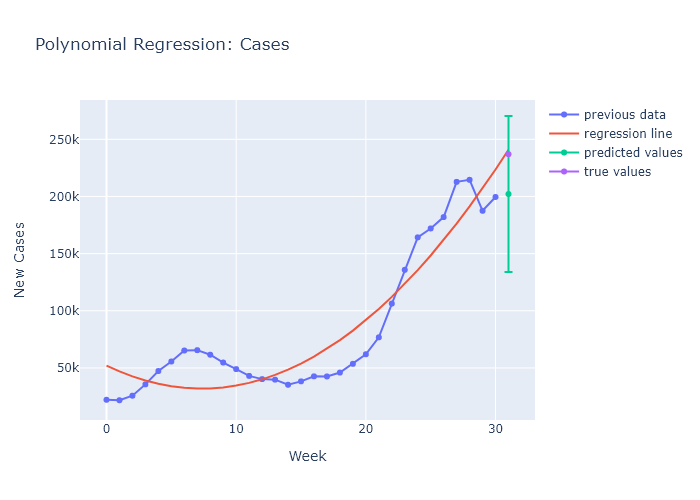

RMSE: 34818.52488100782
ForecastingHorizon([31], dtype='int64', is_relative=False)


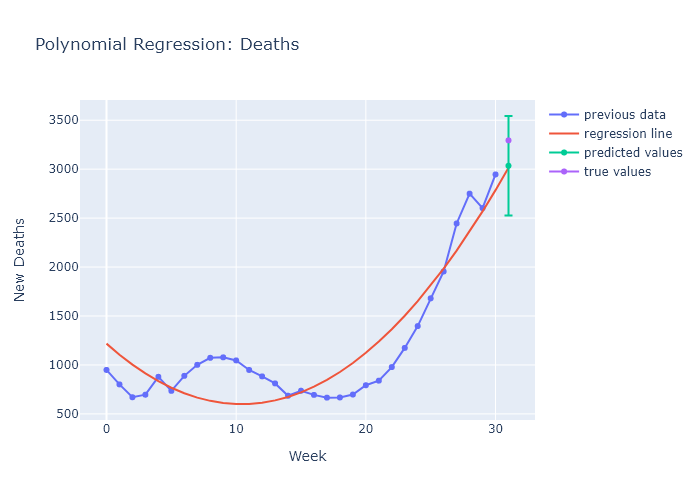

RMSE: 259.2893075201305


In [9]:
# Plot Polynomial Regression
create_reg_plot(cases_weeks, cd = "c", degree = degree, title="Polynomial Regression: Cases")
create_reg_plot(deaths_weeks, cd = "d", degree = degree, title="Polynomial Regression: Deaths")

### Bias vs Variance
Bias is assumptions that the model makes in order to simplify the target function. Too much of it, and you'll end up wih a straight line, regardless of how straight or curved the data is. This is where variance comes in; it acknowledges the actual data trends and starts to curve the target function to fit the model closer to it. In order to get a more accurate regression function, variance is important. However, too much of it, and the model begins overfitting the data, where instead of predicting a function that closely fits the data, the line follows each datapoint to the next. Because it gets so specific in the training set of the data, it becomes more difficult for the model to make predictions on any new dataset. You need a balance between the two in order to get the most efficiently accurate model. 

## Compare with other countries

In [10]:
country_data = pd.read_csv("Country_Data/owid-covid-data.csv")
countries = ["JPN", "BRA", "DEU", "GRL", "CHN", "RUS"] #ISO codes of selected countries: Japan, Brazil, Greenland, China, and Russia 
#location; date; new_cases; new_deaths

In [11]:
def get_country_data(iso : str):
    cols = ["location", "date", "new_cases", "new_deaths"]
    data = country_data[country_data["iso_code"] == iso] #Restrict to country
    data["date"] = pd.to_datetime(data["date"])
    data = data.loc[(data["date"] >= datetime.datetime(2020, 5, 25)) 
                    & (data["date"] <= datetime.datetime(2021, 1, 10)), 
                    data.columns.isin(cols)] #restrict to specific dates and columns
    data=data.loc[~data["new_cases"].eq(0)] #get rid of rows with 0 in "new_cases"
    
    
    data.index = [i for i in range(len(data["location"]))]
    
    data_cases = data.drop("new_deaths", axis = 1)
    data_deaths = data.drop("new_cases", axis = 1)
    
    data_cases = data_cases.rename(columns={"new_cases": "sum"})
    data_deaths = data_deaths.rename(columns={"new_deaths": "sum"})
    
    return data_cases, data_deaths


In [12]:
ccases = []
cdeaths = []
for i in range(len(countries)) :
    cc, cd = get_country_data(countries[i])
    ccases.append(cc)
    cdeaths.append(cd)

C:\Users\leapi\AppData\Local\Temp\ipykernel_35764\964043663.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\leapi\AppData\Local\Temp\ipykernel_35764\964043663.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\leapi\AppData\Local\Temp\ipykernel_35764\964043663.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

ForecastingHorizon([32], dtype='int64', is_relative=False)


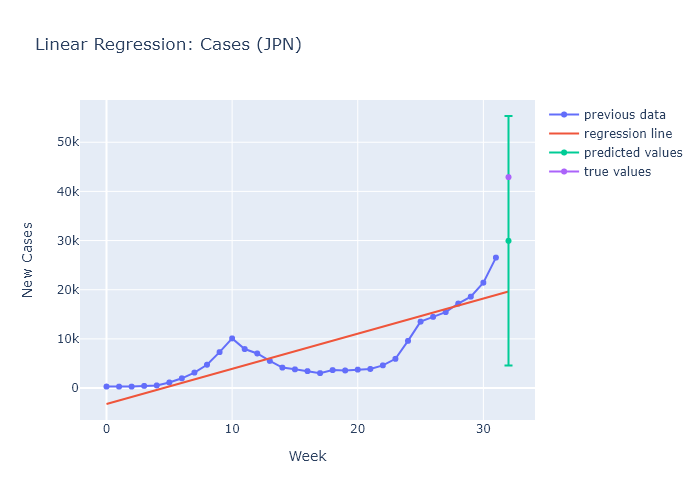

RMSE: 12951.983637333014
ForecastingHorizon([32], dtype='int64', is_relative=False)


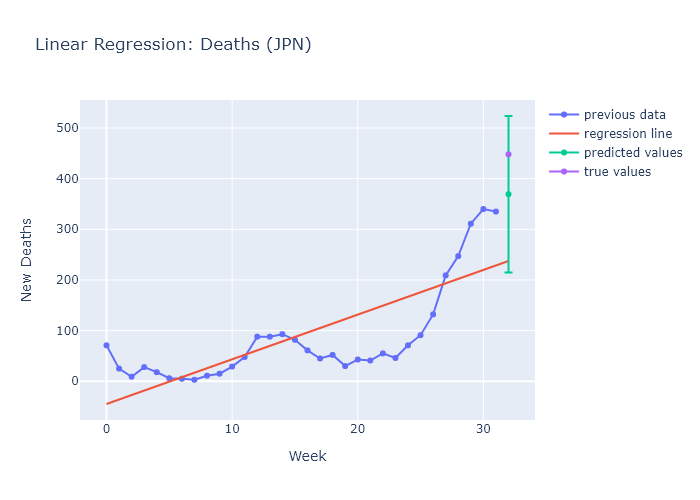

RMSE: 78.77648769865777
ForecastingHorizon([32], dtype='int64', is_relative=False)


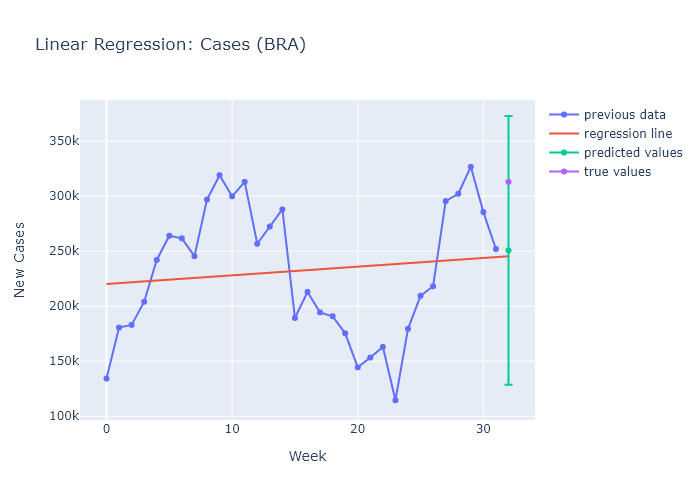

RMSE: 62338.17188510092
ForecastingHorizon([32], dtype='int64', is_relative=False)


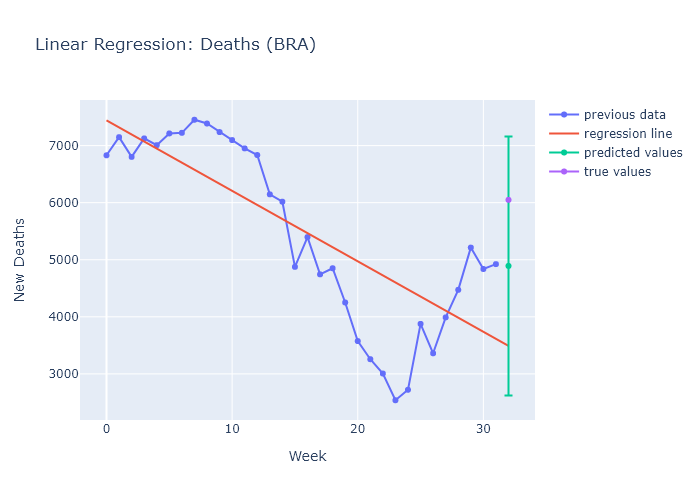

RMSE: 1157.8338654019435
ForecastingHorizon([32], dtype='int64', is_relative=False)


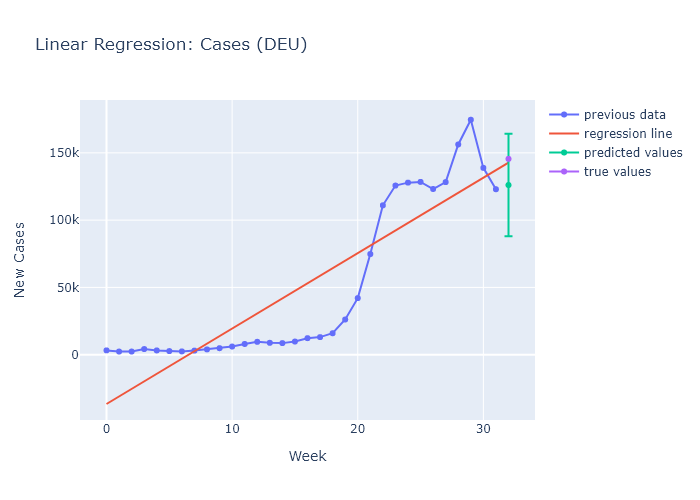

RMSE: 19416.962261745546
ForecastingHorizon([32], dtype='int64', is_relative=False)


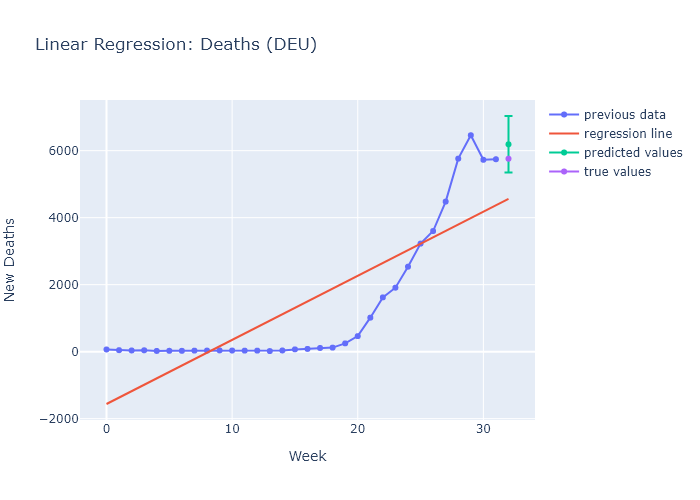

RMSE: 431.0516796746433
ForecastingHorizon([8], dtype='int64', is_relative=False)


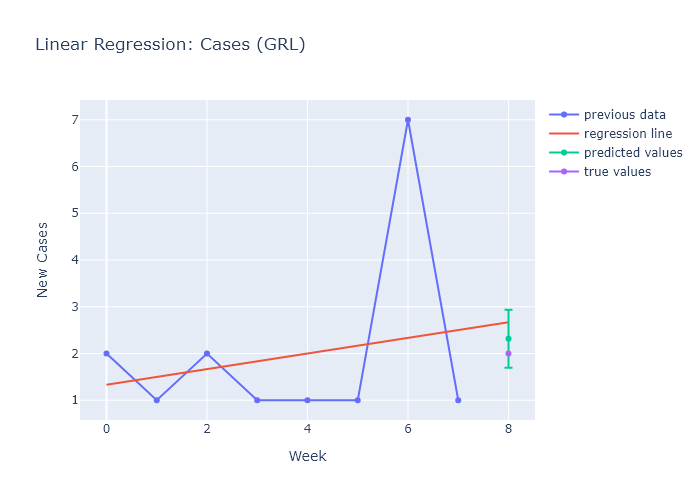

RMSE: 0.31683168316831667
ForecastingHorizon([8], dtype='int64', is_relative=False)


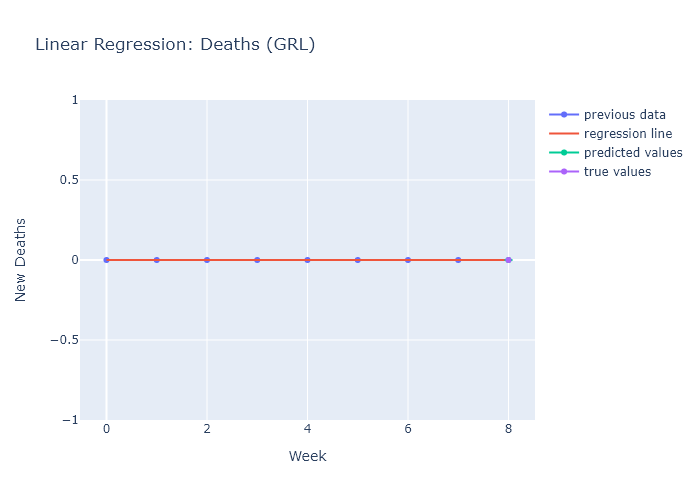

RMSE: 0.0
ForecastingHorizon([32], dtype='int64', is_relative=False)


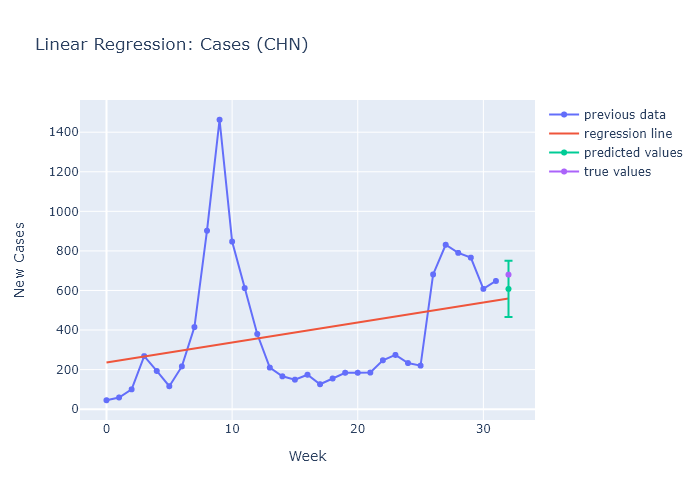

RMSE: 72.53214419790584
ForecastingHorizon([32], dtype='int64', is_relative=False)


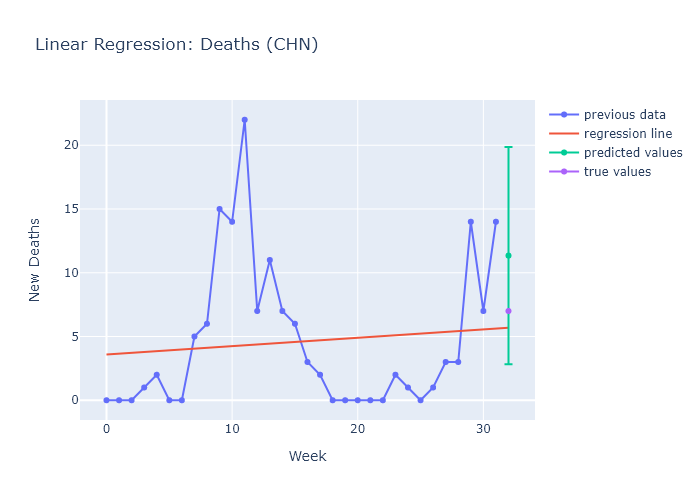

RMSE: 4.345382621743283
ForecastingHorizon([32], dtype='int64', is_relative=False)


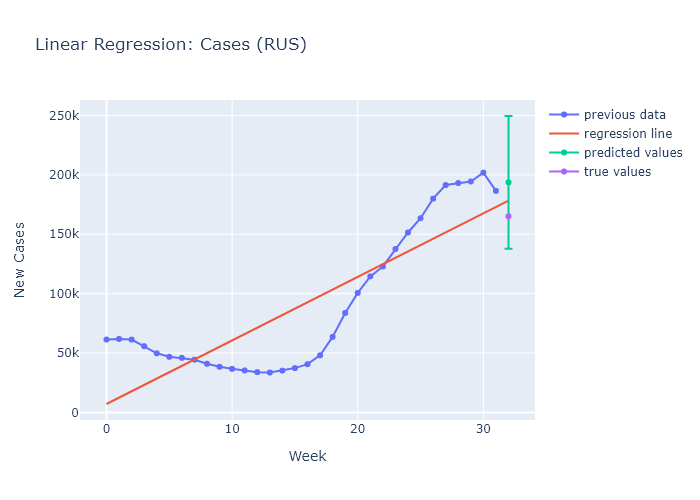

RMSE: 28521.242304933257
ForecastingHorizon([32], dtype='int64', is_relative=False)


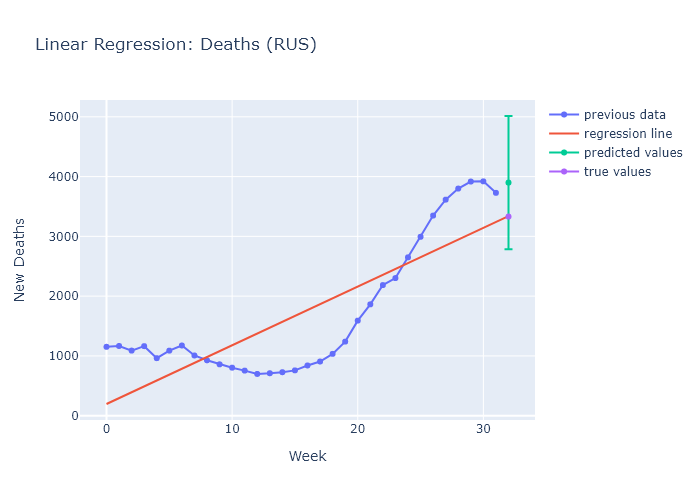

RMSE: 568.4331184076009


In [13]:
#get linear reg graphs
for i in range(len(countries)) :
    create_reg_plot(ccases[i], cd = "c", title="Linear Regression: Cases ({})".format(countries[i]))
    create_reg_plot(cdeaths[i], cd = "d", title="Linear Regression: Deaths ({})".format(countries[i]))

ForecastingHorizon([32], dtype='int64', is_relative=False)


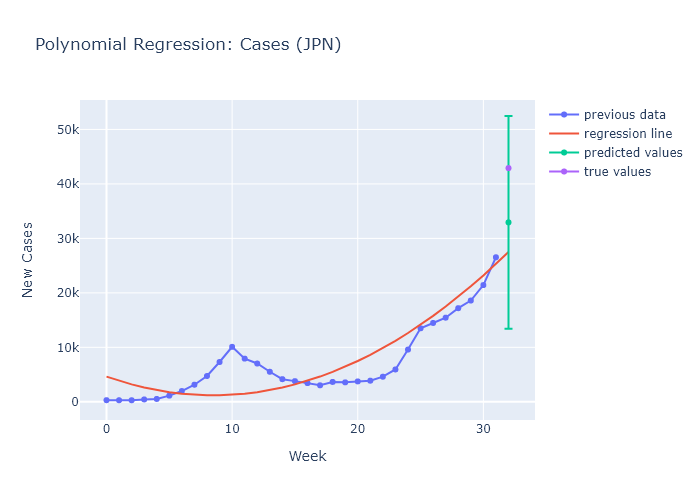

RMSE: 9962.332622220172
ForecastingHorizon([32], dtype='int64', is_relative=False)


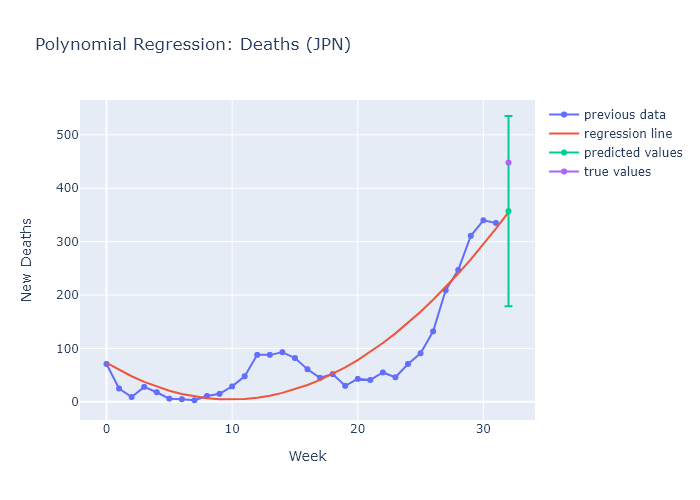

RMSE: 90.92481333766119
ForecastingHorizon([32], dtype='int64', is_relative=False)


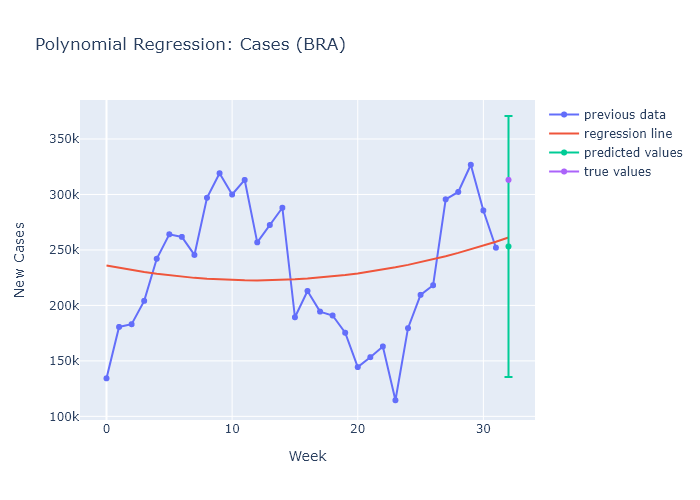

RMSE: 59996.13003914393
ForecastingHorizon([32], dtype='int64', is_relative=False)


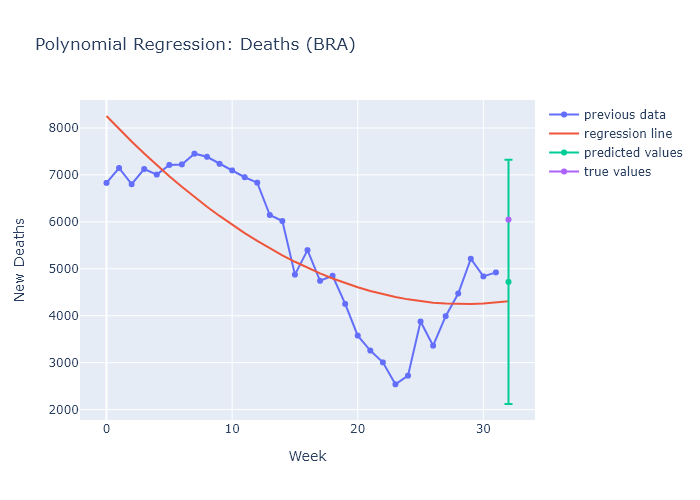

RMSE: 1328.01998624532
ForecastingHorizon([32], dtype='int64', is_relative=False)


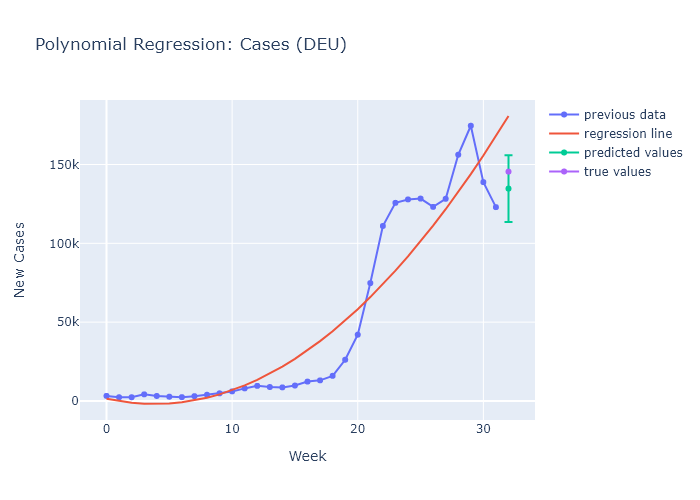

RMSE: 10782.85753803936
ForecastingHorizon([32], dtype='int64', is_relative=False)


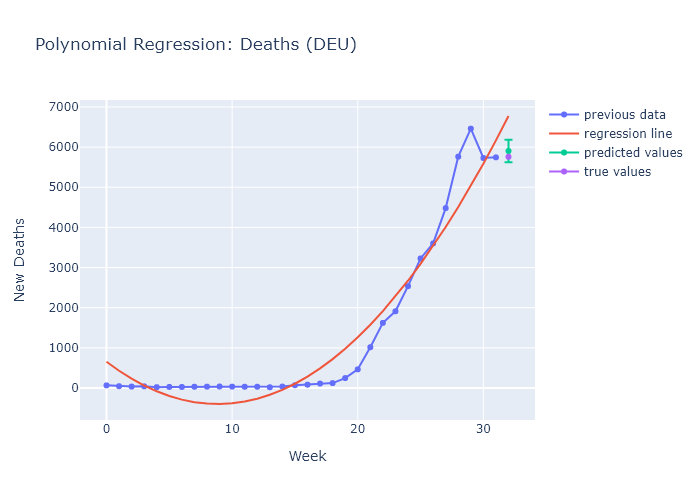

RMSE: 144.18820210925878
ForecastingHorizon([8], dtype='int64', is_relative=False)


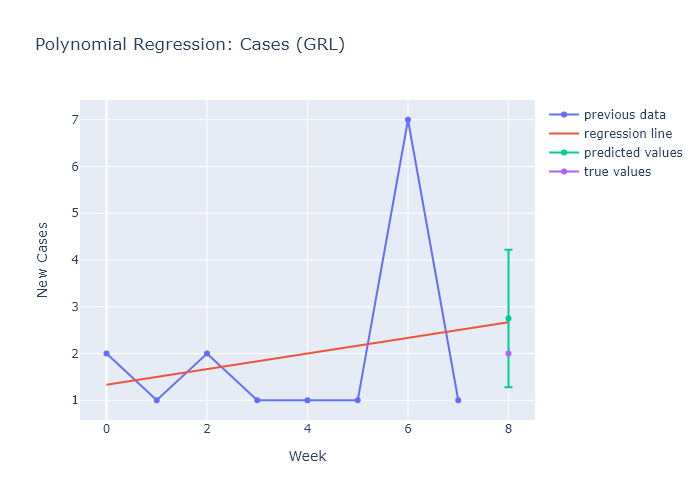

RMSE: 0.7500000000000018
ForecastingHorizon([8], dtype='int64', is_relative=False)


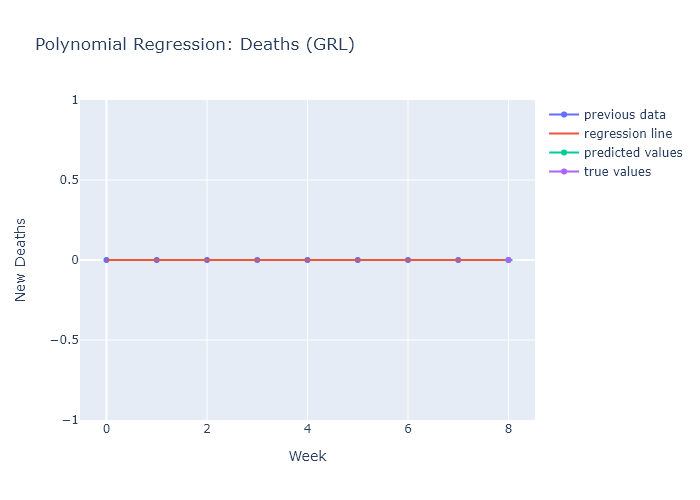

RMSE: 0.0
ForecastingHorizon([32], dtype='int64', is_relative=False)


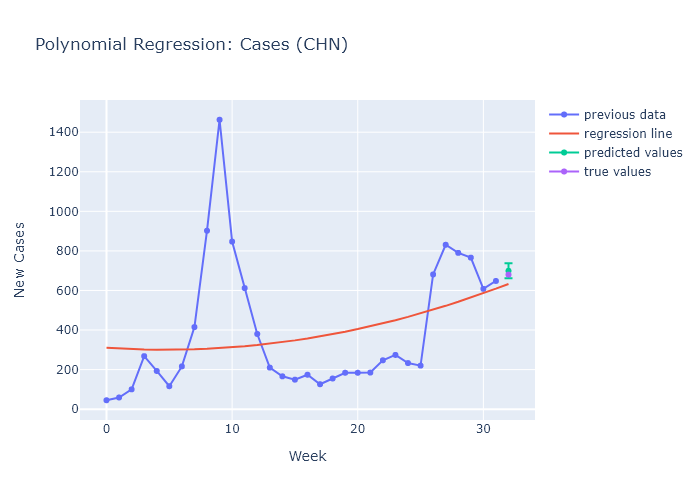

RMSE: 19.407119783479402
ForecastingHorizon([32], dtype='int64', is_relative=False)


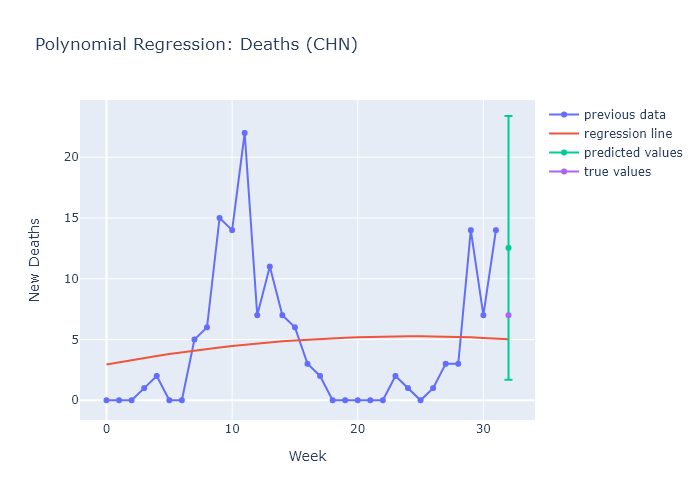

RMSE: 5.538748449155602
ForecastingHorizon([32], dtype='int64', is_relative=False)


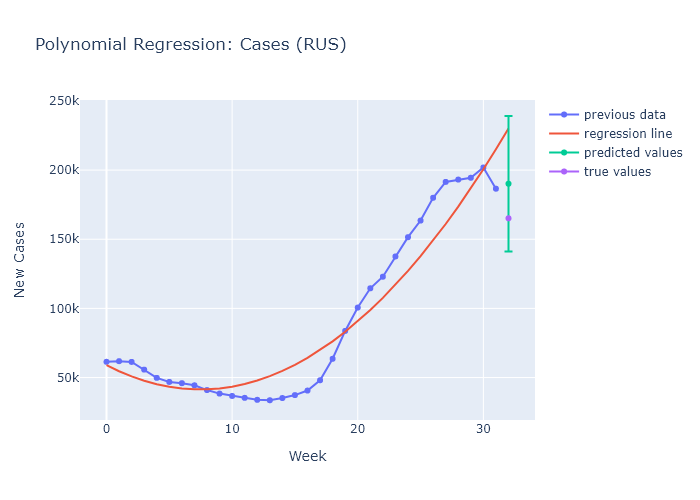

RMSE: 24982.025466060644
ForecastingHorizon([32], dtype='int64', is_relative=False)


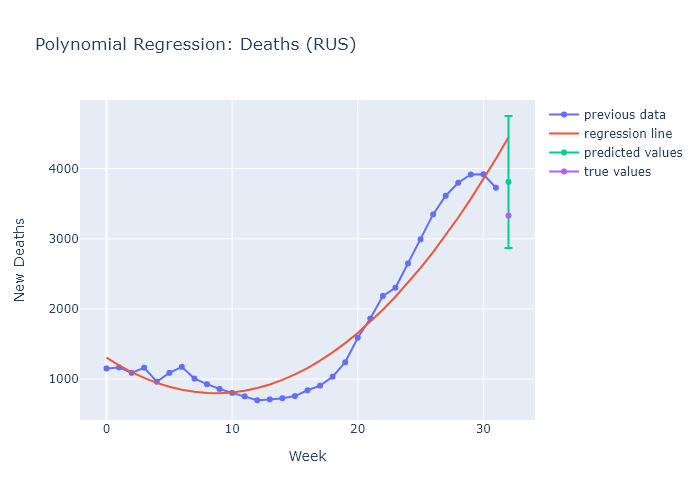

RMSE: 479.7890408798353


In [14]:
#get polynomial reg graphs
for i in range(len(countries)) :
    create_reg_plot(ccases[i], cd = "c", degree = degree, 
                           title="Polynomial Regression: Cases ({})".format(countries[i]))
    create_reg_plot(cdeaths[i], cd = "d", degree = degree, 
                           title="Polynomial Regression: Deaths ({})".format(countries[i]))

### Discussion
- Japan
The regression line is an upward trend. The new cases are trending upward, and the forecasted data predicts increasing new cases over the coming week. The polynomial model predicts the increase at like the linear model. The same pattern is seen for the prediction for new death rates.
- Brazil
The pattern for Brazil is slightly different in that it is unstable, that is, fluctuating in the cases’ linear model. However, in the deaths slope, it was a downward trend indicating a decreasing death rate. This pattern was consistent for both the linear and polynomial models in both cases and deaths in Brazil. The predicted values for cases and deaths did not forecast any sharp increase or sharp decline.
- Germany
The trend of the linear model is an upward view for both cases and deaths. The polynomial model too indicates an upward trend in Germany for both deaths and cases. The polynomial model however predicted lesser cases and lesser deaths in the next week in a slight contrast to the prediction of the linear model for the deaths in the coming week.
- Greenland
The linear model gives a slightly upward trend for the new cases. The deaths however remained stable without increase or decrease for the linear model. The polynomial model was also like the linear model for both cases and deaths.
- China
The polynomial model produced a slightly upward trend for both cases and deaths with the cases more skewed upwards. However, the prediction for the next week was a slight increase.
- Russia
The trend was an upward pattern indicating rises for both the linear and polynomial models in Russia. The models predicted an increase in the coming week. 
- USA
The trend was an upward line indicating rises for both linear and polynomial models for the USA. Both models predict an increase in the coming week. This pattern is the same for both new cases and deaths in the USA.


In summary, the US had the steepest regression lines of the countries, for both linear and polynomial regression. Greenland's polynomial regression lines pretty much looked the same as its linear ones. Brazil was the only country that had a declining linear regression line.